In [1]:
import scanpy as sc
from pathlib import Path
from dask import array as da
from tqdm.dask import TqdmCallback

from scatlastb_utils.io import read_anndata, write_zarr_linked

/Users/michaela.mueller/miniforge3/envs/scanpy_test/lib/python3.11/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [17]:
sc.settings.set_figure_params(dpi=72, dpi_save=100, figsize=(4, 4), frameon=False)

In [2]:
dataset_name = 'Hrovatin2023'
file_path = f'data/{dataset_name}.h5ad'

# Get data

In [3]:
def get_cxg_url(collection_id, dataset_id):
    """
    Adapted code from https://github.com/chanzuckerberg/single-cell-curation/blob/main/notebooks/curation_api/python_raw/get_dataset.ipynb
    """
    import requests
    print(f'Get URL for CxG collection ID "{collection_id}" and dataset ID "{dataset_id}"')

    url = f'https://api.cellxgene.cziscience.com/curation/v1/collections/{collection_id}/datasets/{dataset_id}/'
    assets = requests.get(url=url).json()['assets']
    asset = [a for a in assets if a["filetype"] == "H5AD"][0]
    url = asset["url"]

    print(f'URL: {url}')
    return url

In [4]:
url = get_cxg_url(
    collection_id="296237e2-393d-4e31-b590-b03f74ac5070",
    dataset_id="49e4ffcc-5444-406d-bdee-577127404ba8"
)

Get URL for CxG collection ID "296237e2-393d-4e31-b590-b03f74ac5070" and dataset ID "49e4ffcc-5444-406d-bdee-577127404ba8"
URL: https://datasets.cellxgene.cziscience.com/49243c50-bf0c-4b10-87f8-55ec9f455399.h5ad


In [5]:
# download only if the file does not exist
!curl -C - -o {file_path} {url}

** Resuming transfer from byte position 4072839821
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    49  100    49    0     0    663      0 --:--:-- --:--:-- --:--:--   710


In [6]:
adata = read_anndata(
    file_path,
    X='raw/X',
    obs='obs',
    var='var',
    obsm='obsm',
    obsp='obsp',
    dask=True,
    backed=True,
    stride=50_000
)
adata

dask: True, backed: True
chunks: (50000, -1)
Read slot "raw/X", store as "X"...
Read raw/X as backed sparse dask array...
Read slot "obs", store as "obs"...
Read slot "var", store as "var"...
Read slot "obsm", store as "obsm"...


Read obsm slots as_dask=False: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 50.20it/s]

Read slot "obsp", store as "obsp"...
shape: (301796, 30849)


AnnData object with n_obs × n_vars = 301796 × 30849
    obs: 'batch_integration', 'dataset', 'design', 'cell_cycle_phase', 'ins_high', 'gcg_high', 'sst_high', 'ppy_high', 'cell_filtering', 'strain', 'age', 'cell_type_originalDataset_unified', 'cell_type_originalDataset', 'cell_type_reannotatedIntegrated', 'n_genes', 'mt_frac', 'doublet_score', 'log10_n_counts', 'age_approxDays', 'dataset__design__sample', 'cell_subtype_immune_reannotatedIntegrated', 'cell_subtype_endothelial_reannotatedIntegrated', 'emptyDrops_LogProb_scaled', 'cell_subtype_beta_coarse_reannotatedIntegrated', 'cell_subtype_beta_fine_reannotatedIntegrated', 'GP_1', 'GP_2', 'GP_3', 'GP_4', 'GP_5', 'GP_6', 'GP_7', 'GP_8', 'GP_9', 'GP_10', 'GP_11', 'GP_12', 'GP_13', 'GP_14', 'GP_15', 'GP_16', 'GP_17', 'GP_18', 'GP_19', 'GP_20', 'GP_21', 'GP_22', 'GP_23', 'GP_24', 'GP_25', 'GP_26', 'GP_27', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'diabetes_model', 'chemical_stress', 'GEO

## Visualise data

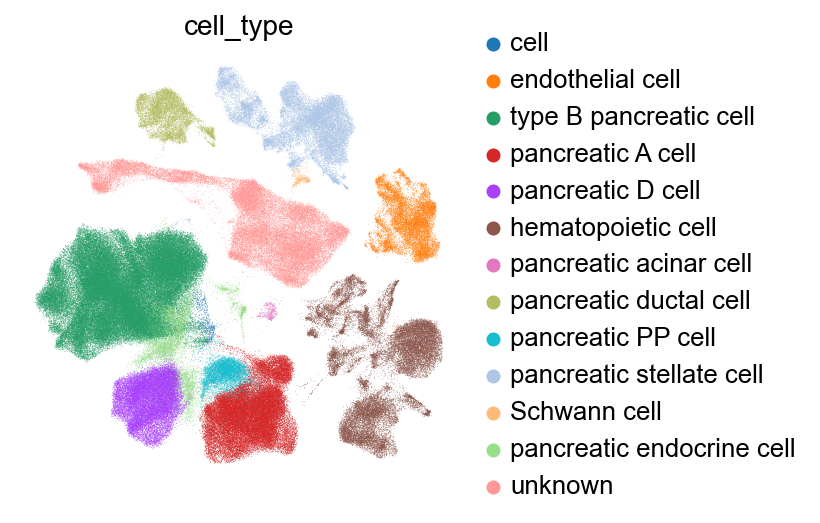

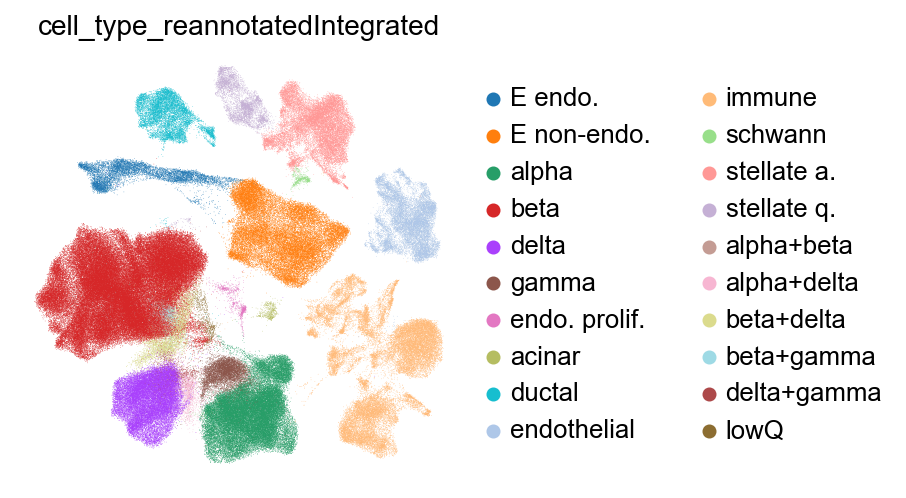

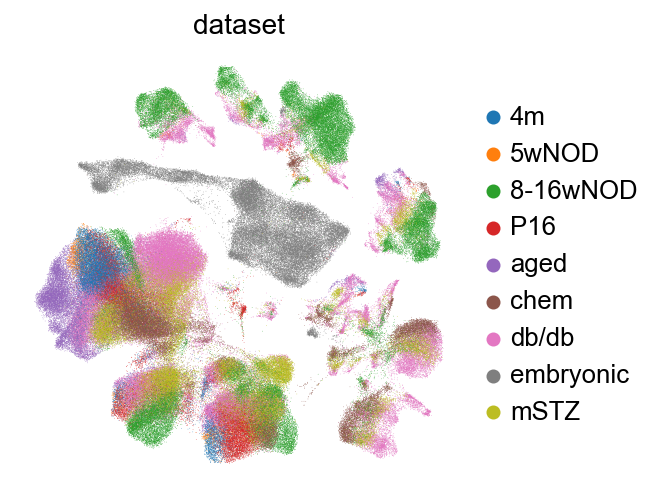

In [18]:
for color in ['cell_type', 'cell_type_reannotatedIntegrated', 'dataset']:
    sc.pl.embedding(
        adata,
        'X_integrated_umap',
        color=color,
        frameon=False,
    )

# Preprocess data

Example of a simple preprocessing workflow with `scanpy`. Notably, the count matrices are stored as backed dask arrays, so that all subsequent operations will be executed lazily.
If you want to load any backed matrix in `adata` to memory, you can always use the `compute` command.

In [8]:
adata.layers['counts'] = adata.X.copy()

In [9]:
sc.pp.normalize_total(adata)

In [10]:
sc.pp.log1p(adata)

In [11]:
%%time
sc.pp.highly_variable_genes(adata, n_top_genes=2000)

CPU times: user 43.2 s, sys: 14.9 s, total: 58.1 s
Wall time: 43.3 s


In [12]:
%%time
sc.pp.pca(adata, n_comps=50, mask_var='highly_variable')

CPU times: user 46.6 s, sys: 11.8 s, total: 58.3 s
Wall time: 41.1 s


In [13]:
%%time
sc.pp.neighbors(adata, use_rep='X_pca')

CPU times: user 1min 36s, sys: 17 s, total: 1min 53s
Wall time: 1min 34s


In [14]:
%%time
sc.tl.umap(adata)

CPU times: user 5min 59s, sys: 26.3 s, total: 6min 25s
Wall time: 3min 26s


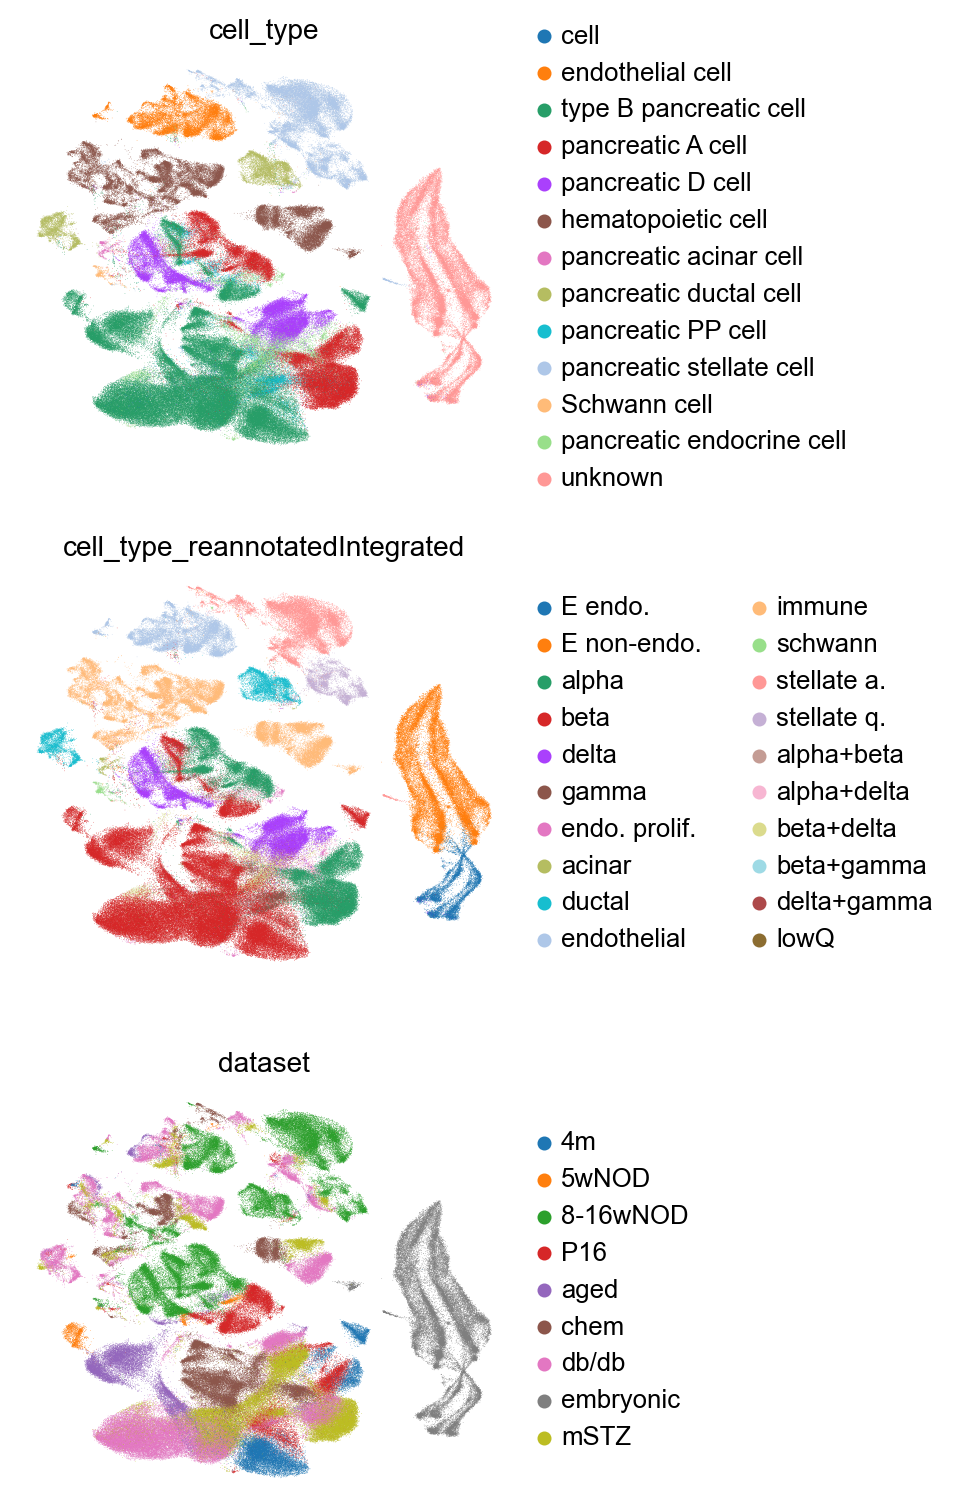

In [19]:
sc.pl.umap(
    adata,
    color=[
        'cell_type',
        'cell_type_reannotatedIntegrated',
        'dataset',
    ],
    ncols=1,
    frameon=False,
)

In [16]:
%%time
adata.write_zarr(f'data/{dataset_name}_preprocessed.zarr')

CPU times: user 2min 14s, sys: 44.6 s, total: 2min 59s
Wall time: 2min 39s
